In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import feature_selection as fs
from sklearn import linear_model
import sklearn.metrics as sklm
from datetime import date

%matplotlib inline

In [12]:
def calc_age(birthday):
    today = date(1998, 1, 1)
    birthday = list(map(int, birthday.split('-')))
    born = date(birthday[0], birthday[1], birthday[2])
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def import_clean():
    # imports features and labels
    import_features = pd.read_csv('AdvWorksCusts.csv')
    import_labels = pd.read_csv('AW_AveMonthSpend.csv')
    import_features = import_features.drop_duplicates(subset='CustomerID')
    import_labels = import_labels.drop_duplicates(subset='CustomerID')

    temp = import_features.merge(import_labels, how='left', on='CustomerID')
    temp['Age'] = [calc_age(birthday) for birthday in temp['BirthDate']]

    cat_cols = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'CountryRegionName']
    num_cols = ['Age', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned']
    cat_already_encoded = ['HomeOwnerFlag']
    
    Labels = np.array(temp['AveMonthSpend'])
    # Features has 15 categorical features, that have been one hot encoded
    Features = encode_string(temp[cat_cols])
    Features = np.concatenate([Features, np.array(temp[cat_already_encoded])], axis=1)
    num_cat = Features.shape[1]
    # concatenate numeric features
    Features = np.concatenate([Features, np.array(temp[num_cols])], axis=1)
    return Features, Labels, num_cat

def encode_string(cat_features):
    ohe = preprocessing.OneHotEncoder(categories = 'auto')
    encoded = ohe.fit(cat_features)
    return encoded.transform(cat_features).toarray()

# create training, test sets
def create_sets(Features, Labels):
    nr.seed(9988)
    indx = range(Features.shape[0])
    indx = ms.train_test_split(indx, test_size = .3)
    X_train = Features[indx[0],:]
    y_train = np.ravel(Labels[indx[0]])
    X_test = Features[indx[1],:]
    y_test = np.ravel(Labels[indx[1]])
    return X_train, y_train, X_test, y_test

def scale(features, num_cat):
    scaler = preprocessing.StandardScaler().fit(features[:, num_cat:])
    features[:,num_cat:] = scaler.transform(features[:, num_cat:])
    return features, scaler

Features, Labels, num_cat = import_clean()
Features, scaler = scale(Features, num_cat)
X_train, y_train, X_test, y_test = create_sets(Features, Labels)

In [13]:
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [14]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 28)  

Mean Square Error      = 39.555281464281435
Root Mean Square Error = 6.289298964453943
Mean Absolute Error    = 4.7948178101825984
Median Absolute Error  = 3.828857421875
R^2                    = 0.9466394460993212
Adjusted R^2           = 0.9463450580822965


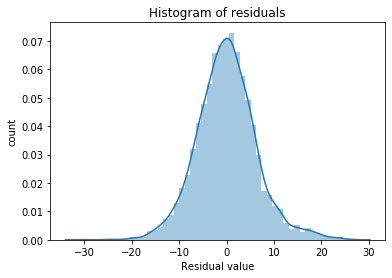

In [15]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)   

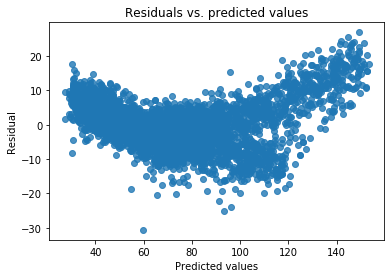

In [16]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score) 

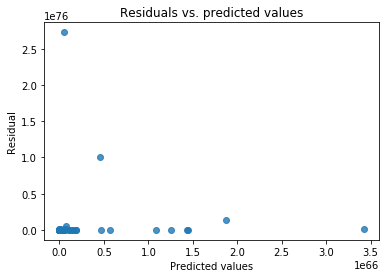

In [17]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform) 

In [19]:
def calc_age_test(birthday):
    today = date(1998, 1, 1)
    birthday = list(map(int, birthday.split('/')))
    born = date(birthday[2], birthday[0], birthday[1])
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

test = pd.read_csv('AW_test.csv')
test['Age'] = [calc_age_test(birthday) for birthday in test['BirthDate']]

cat_cols = ['Education', 'Occupation', 'Gender', 'MaritalStatus', 'CountryRegionName']
num_cols = ['Age', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned']
cat_already_encoded = ['HomeOwnerFlag']

Features = encode_string(test[cat_cols])
Features = np.concatenate([Features, np.array(test[cat_already_encoded])], axis=1)
print(Features.shape)
Features = np.concatenate([Features, np.array(test[num_cols])], axis=1)
print(Features.shape)
Features[:,21:] = scaler.transform(Features[:,21:])

test_score = lin_mod.predict(Features)

(500, 21)
(500, 26)


In [21]:
test_out = pd.DataFrame(test_score)
#test_out.to_csv('test2.csv')